In [1]:
import torch
from torchvision.models import squeezenet1_1
from torchvision.models import shufflenet_v2_x2_0
from torchvision.models import mobilenet_v2
from torchvision.models import efficientnet_b0
from torchvision.models import resnet50
from torchvision.models import densenet121
from torch.nn import CrossEntropyLoss
from torch.optim import SGD,Adam
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Conv2d, Conv3d, functional as F, Linear, MaxPool2d, Module
from torch import max, no_grad
from torchmetrics import F1Score
from torch.utils.data import Dataset
from PIL import Image
import os

In [2]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn
import pandas as pd
from pprint import pprint as pp

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device("cpu")

In [5]:
class_num = 9
CLASSES = ('Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative')

In [6]:
images_dir="./defence/images/"
train_dir="./defence/labels/train_subset0.csv"
val_dir="./defence/labels/val_subset0.csv"
test_dir="./defence/labels/test_subset0.csv"


In [7]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [8]:
models = {
    "SqueezeNet": {
        'model' : squeezenet1_1(pretrained=True),
        'train_transform': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]),
        'test_transform': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]),
        'val_transform': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]),
        'num_epochs': 25,
        'learning_rate': 1e-5,
    },
}

/Users/hasnat/jupyter/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hasnat/jupyter/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def get_loaders(train_transform, test_transform, validation_transform, batch_size=32):
    train_set = CustomDataset(train_dir, images_dir, transform=train_transform)
    val_set = CustomDataset(val_dir, images_dir, transform=val_transform)
    test_set = CustomDataset(test_dir, images_dir, transform=test_transform)

    
    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
    )


    val_loader = DataLoader(
        dataset=val_set,
        batch_size=batch_size,
    )

    test_loader = DataLoader(
        dataset=test_set,
        batch_size=batch_size,
    )
    
    return [train_loader, val_loader, test_loader]

In [10]:
def train_model(model, epochs, lr, train_loader, val_loader):
  history = {
      "train_loss": [],
      "val_loss": [],
      "train_acc": [],
      "val_acc": []
  }
  loss_fn = CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=lr)
  
  for epoch in range(epochs):
    print(f"Epoch: {epoch+1} running...")
    model.train()

    i=0
    acc=0
    running_loss = 0
    for inputs, labels in train_loader:
      i+=1
      if epoch == 0: print(f"Input Batch: {i}/{len(train_loader)}")
      inputs,labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      running_loss += loss.item()
      _, preds = max(outputs.data, dim=1)
      current_acc = torch.tensor(torch.sum(preds==labels).item() / len(preds))
      acc+=current_acc
      loss.backward()
      optimizer.step()
    loss_train = running_loss/len(train_loader)
    acc_train = (acc/len(train_loader)).item()      
    history["train_acc"].append(acc_train)
    history["train_loss"].append(loss_train)
    model.eval()
    loss_val = 0
    passes = 0
    acc = 0
    with no_grad():
      for inputs, labels in val_loader:
        inputs,labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_val += loss_fn(outputs, labels)
        _, preds = max(outputs.data, dim=1)
        current_acc = torch.tensor(torch.sum(preds==labels).item() / len(preds))
        acc+=current_acc
        passes += 1
    loss_val = (loss_val/len(val_loader)).item()
    acc_val = (acc/len(val_loader)).item()
    history["val_acc"].append(acc_val)
    history["val_loss"].append((loss_val))
    print(f"Epoch[{epoch+1}/{epochs}]\nval_loss: {loss_val}, train_loss: {loss_train}\nval_acc: {acc_val}, train_acc: {acc_train}")
  return [history, optimizer]

In [11]:
def test_model(model, test_loader):
    model.eval()
    loss = 0
    loss_fn = CrossEntropyLoss()
    passes = 0
    acc = 0
    f = 0
    with no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += loss_fn(outputs, labels)
            _, preds = max(outputs.data, dim=1)
            current_acc = torch.tensor(torch.sum(preds==labels).item() / len(preds))
            current_f = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
            acc += current_acc
            f += current_f
            passes += 1
            print(f"acc: {current_acc}, f1_s: {current_f}")
    final_acc = (acc/passes).item()
    final_f = (f/passes).item()
    print(f"Accuracy: {final_acc}, F1_score: {final_f}")
    return [final_acc, final_f]


In [12]:
def show_plots(history):
    e = np.array([x for x in range(1, len(history['train_loss'])+1)])
    t_loss = np.array(history['train_loss'])
    v_loss = np.array(history['val_loss'])
    t_acc = np.array(history['train_acc'])
    v_acc = np.array(history['val_acc'])
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Number of Epochs vs Loss")

    plt.plot(e, t_loss)
    plt.plot(e, v_loss, color='orange')

    blue_patch = mpatches.Patch(color='blue', label='Training')
    orange_patch = mpatches.Patch(color='orange', label='Validation')
    plt.legend(handles=[blue_patch, orange_patch])
    
    plt.savefig("Number of Epochs vs Loss")
    plt.show()
    

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Number of Epochs vs Accuracy")

    plt.plot(e, t_acc)
    plt.plot(e, v_acc, color='orange')

    blue_patch = mpatches.Patch(color='blue', label='Training')
    orange_patch = mpatches.Patch(color='orange', label='Validation')
    plt.legend(handles=[blue_patch, orange_patch])
    
    plt.savefig("Number of Epochs vs Accuracy")
    plt.show()
    

In [13]:
def show_confusion_matrix(model, test_loader, classes):
    y_pred = []
    y_true = []

    model.eval()
    with no_grad():
      for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Confusion Matrix")
    plt.savefig("Confusion Matrix")
    plt.show()

In [14]:
def train_and_plot(model,train_loader, val_loader, test_loader, epochs, lr):
   
    model.to(device)
    
    if torch.backends.mps.is_available():
        model.classifier[1] = Conv2d(512, class_num, kernel_size=(1, 1), stride=(1, 1),device="mps")
    elif torch.cuda.is_available():
        model.classifier[1] = Conv2d(512, class_num, kernel_size=(1, 1), stride=(1, 1),device="cuda:0")
    else:
        model.classifier[1] = Conv2d(512, class_num, kernel_size=(1, 1), stride=(1, 1))
    


    
    history, optimizer = train_model(model, epochs, lr, train_loader, val_loader)
    acc, f1 = test_model(model, test_loader)
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': acc,
        'f1_score': f1,
        'history_dict': history,
    }, "defence.pt")
    show_plots(history)
    show_confusion_matrix(model, test_loader, CLASSES)

Epoch: 1 running...
Input Batch: 1/329
Input Batch: 2/329
Input Batch: 3/329
Input Batch: 4/329
Input Batch: 5/329
Input Batch: 6/329
Input Batch: 7/329
Input Batch: 8/329
Input Batch: 9/329
Input Batch: 10/329
Input Batch: 11/329
Input Batch: 12/329
Input Batch: 13/329
Input Batch: 14/329
Input Batch: 15/329
Input Batch: 16/329
Input Batch: 17/329
Input Batch: 18/329
Input Batch: 19/329
Input Batch: 20/329
Input Batch: 21/329
Input Batch: 22/329
Input Batch: 23/329
Input Batch: 24/329
Input Batch: 25/329
Input Batch: 26/329
Input Batch: 27/329
Input Batch: 28/329
Input Batch: 29/329
Input Batch: 30/329
Input Batch: 31/329
Input Batch: 32/329
Input Batch: 33/329
Input Batch: 34/329
Input Batch: 35/329
Input Batch: 36/329
Input Batch: 37/329
Input Batch: 38/329
Input Batch: 39/329
Input Batch: 40/329
Input Batch: 41/329
Input Batch: 42/329
Input Batch: 43/329
Input Batch: 44/329
Input Batch: 45/329
Input Batch: 46/329
Input Batch: 47/329
Input Batch: 48/329
Input Batch: 49/329
Input Bat

Epoch[11/25]
val_loss: 0.8798742890357971, train_loss: 0.8406585367979612
val_acc: 0.6886800527572632, train_acc: 0.7032674551010132
Epoch: 12 running...
Epoch[12/25]
val_loss: 0.9640063643455505, train_loss: 0.8199992545832254
val_acc: 0.6385708451271057, train_acc: 0.7176671624183655
Epoch: 13 running...
Epoch[13/25]
val_loss: 0.956219494342804, train_loss: 0.8181801904842122
val_acc: 0.655441403388977, train_acc: 0.7131838798522949
Epoch: 14 running...
Epoch[14/25]
val_loss: 0.9618878364562988, train_loss: 0.7883550233029305
val_acc: 0.6472246050834656, train_acc: 0.7264627814292908
Epoch: 15 running...
Epoch[15/25]
val_loss: 0.8347346782684326, train_loss: 0.768806277437413
val_acc: 0.7012019157409668, train_acc: 0.731440007686615
Epoch: 16 running...
Epoch[16/25]
val_loss: 0.8807377219200134, train_loss: 0.7494221446543117
val_acc: 0.6827359795570374, train_acc: 0.7360942363739014
Epoch: 17 running...
Epoch[17/25]
val_loss: 0.9256411194801331, train_loss: 0.7383168105115282
val_ac

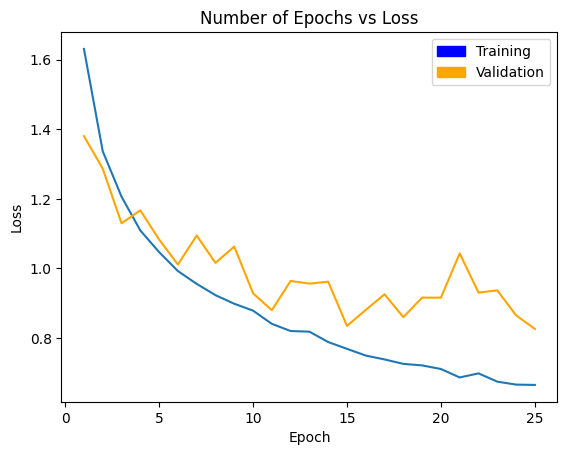

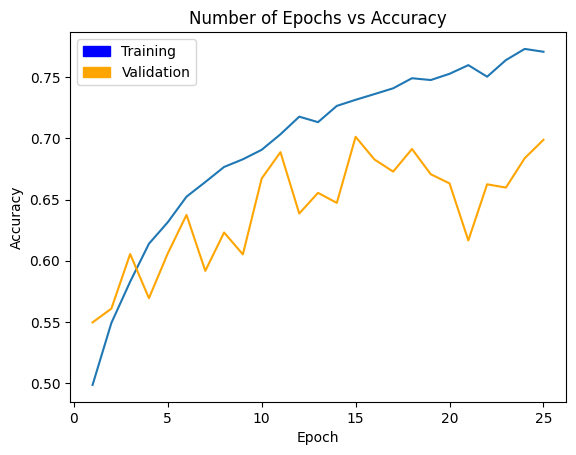

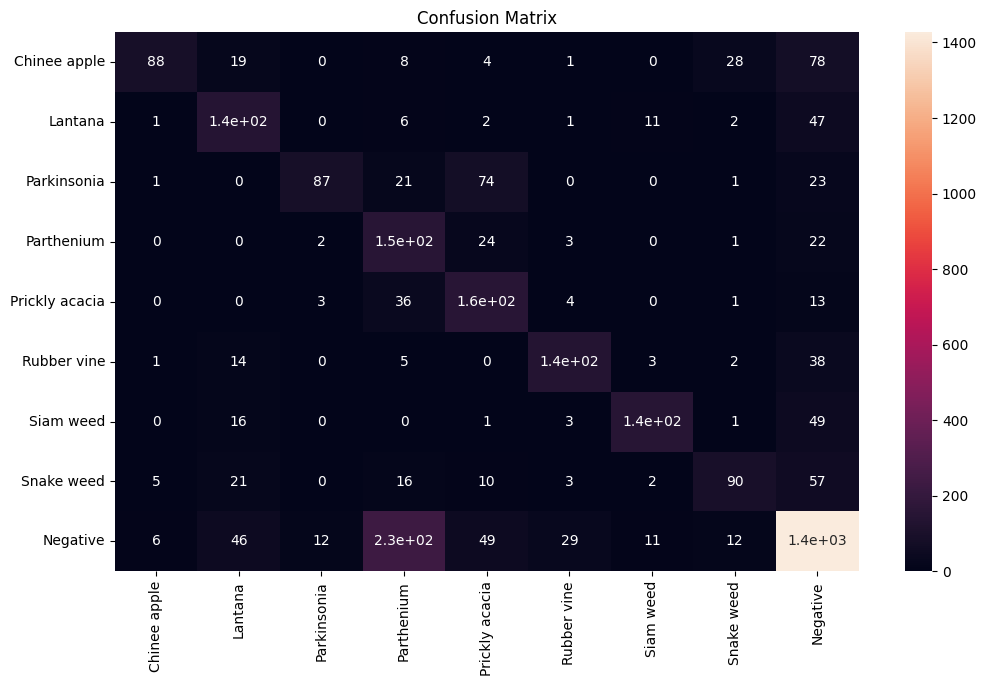

In [15]:
model = models["SqueezeNet"]["model"]
train_transform = models["SqueezeNet"]["train_transform"]
test_transform = models["SqueezeNet"]["test_transform"]
val_transform = models["SqueezeNet"]["val_transform"]
batch_size = 32
epochs = models["SqueezeNet"]["num_epochs"]
lr = models["SqueezeNet"]["learning_rate"]

train_loader, val_loader, test_loader = get_loaders(train_transform, test_transform, val_transform, batch_size)
train_and_plot(model,train_loader, val_loader, test_loader, epochs, lr)